In [16]:
import os
import sys

os.chdir('d:\\Windows\\Documentos\\BAMB2024-main\\bamb\\Bamb_Confidence_Database_Modeling\\Functions')
sys.path.append(os.getcwd())

from secondOrder_fleming_function import compute_meta_conf
import random
import numpy as np
from scipy.stats import multivariate_normal, norm
import pandas as pd
from secondOrder_fleming_function import compute_meta_conf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS


### Run the simulation for serial dependence model in Xconf

In [17]:
theta = [0/6, 1/6, 2/6, 3/6, 4/6, 5/6, 6/6] # I changed a little, because is very easy so far 
sigmaAct = 2  # 1
sigmaConf = 2 # 1
rho = 0.5 # 0.5
bigSigma = np.array([[sigmaAct**2, rho * sigmaAct * sigmaConf], [rho * sigmaAct * sigmaConf, sigmaConf**2]])

# serial dependence weight. alpha = 3 and beta = 7 gives a E[p] of 0.3 given the ecuation alpha/(alpha+beta)
serial_dependence_weight_alpha = 3 
serial_dependence_weight_beta = 7

N = 1000  # N trials

# Initialize lists to store results
data = {
    "theta": [],
    "d": [],
    "a": [],
    "confidence": [],
    "correctness": []
}

first_trial = True
last_xp = np.empty(N)


for t in theta:
    for i in range(N):
        current_theta = t
        d = 1 if np.random.rand() > 0.5 else -1
        
        r = multivariate_normal.rvs(mean=[d * current_theta, d * current_theta], cov=bigSigma)
        
        xa = r[0]
        xp = r[1]
        
        if xa > 0:
            a = 1
            flip_a = 1
        else:
            a = -1
            flip_a = 0

        if first_trial == False:
            p_serial_dependence = np.random.beta(serial_dependence_weight_alpha, serial_dependence_weight_beta, 1)[0]
            
            xp_new = xp * (1-p_serial_dependence) + last_xp[i-1] * p_serial_dependence
            
            conf = compute_meta_conf(np.array([xp_new]), flip_a, sigmaAct, sigmaConf, rho)[0]

            last_xp[i] = xp
        else:
            last_xp[i] = xp
            conf = compute_meta_conf(np.array([xp]), flip_a, sigmaAct, sigmaConf, rho)[0] # 
    
        first_trial = False
        
        data["theta"].append(f"theta_{int(t*6)}")
        data["d"].append(d)
        data["a"].append(a)
        data["confidence"].append(conf)
        data["correctness"].append("correct" if d == a else "incorrect")


# Convert results dictionary to DataFrame
df_results = pd.DataFrame(data)

C:\Users\marcosembon\AppData\Local\Temp\ipykernel_4440\2310573248.py:9: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.stripplot(x="theta", y="confidence", hue="correctness", data=df_results, dodge=True, jitter=True, color='k', alpha=0.1)


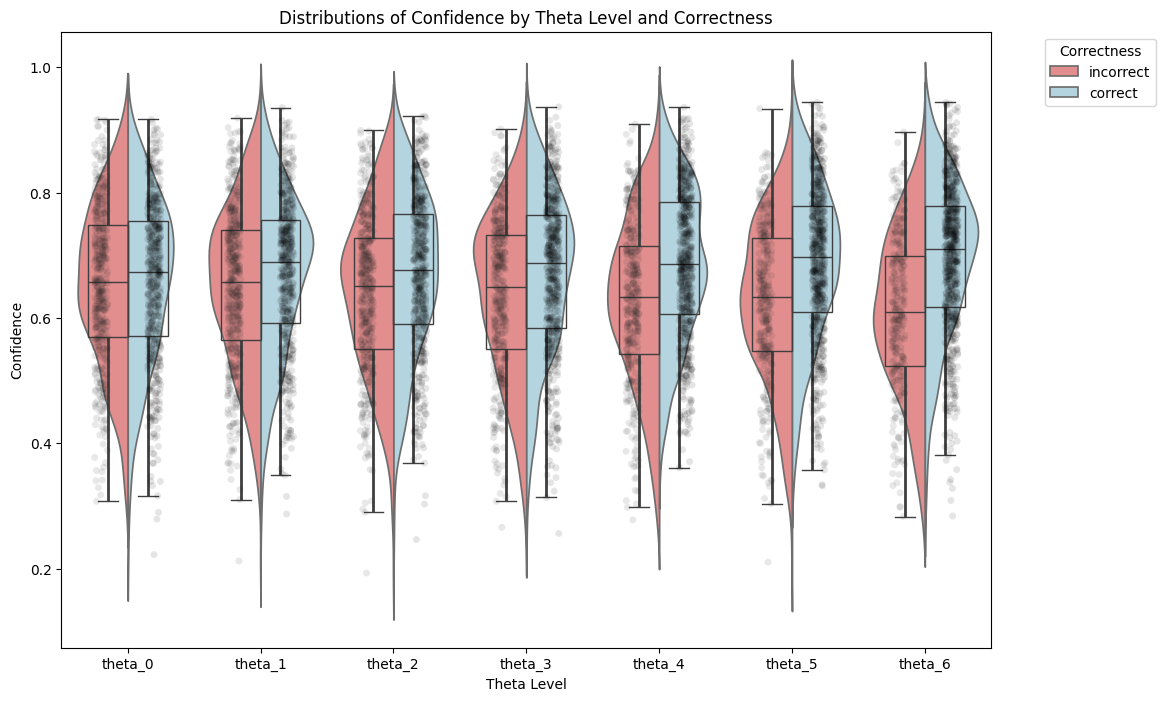

In [18]:
plt.figure(figsize=(12, 8))

palette = {"correct": "lightblue", "incorrect": "lightcoral"}

sns.violinplot(x="theta", y="confidence", hue="correctness", data=df_results, split=True, inner=None, palette=palette)

sns.boxplot(x="theta", y="confidence", hue="correctness", data=df_results, width=0.6, showcaps=True, boxprops={'facecolor':'None'}, showfliers=False, whiskerprops={'linewidth':2})

sns.stripplot(x="theta", y="confidence", hue="correctness", data=df_results, dodge=True, jitter=True, color='k', alpha=0.1)

handles, labels = plt.gca().get_legend_handles_labels()
n = len(df_results['correctness'].unique())
plt.legend(handles[:n], labels[:n], title='Correctness', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.title('Distributions of Confidence by Theta Level and Correctness')
plt.xlabel('Theta Level')
plt.ylabel('Confidence')
plt.show()

In [19]:
df_results.head()

,theta,d,a,confidence,correctness
0,theta_0,1,-1,0.456507,incorrect
1,theta_0,-1,1,0.652674,incorrect
2,theta_0,-1,1,0.641928,incorrect
3,theta_0,-1,1,0.618850,incorrect
4,theta_0,-1,1,0.422014,incorrect


### Run a linear regression model for theta level, trying to find serial dependence

In [20]:
# Crear DataFrame para almacenar los resultados
results = {
    "theta": [],
    "beta": [],
    "intercept": [],
    "p-value": [],
    "conf_int_low": [],
    "conf_int_high": []
}

# Iterar sobre cada nivel de theta
for t in df_results['theta'].unique():
    # Filtrar datos por theta
    df_theta = df_results[df_results['theta'] == t]
    
    # Asegurar que los datos están ordenados correctamente
    df_theta = df_theta.sort_index()
    
    # Crear las variables para la regresión
    X = df_theta['confidence'].shift(1).dropna()
    y = df_theta['confidence'].iloc[1:]
    
    # Añadir constante para el intercepto
    X = sm.add_constant(X)
    
    # Ajustar el modelo
    model = OLS(y, X).fit()
    
    # Extraer los valores deseados
    beta = model.params['confidence']
    intercept = model.params['const']
    p_value = model.pvalues['confidence']
    conf_int = model.conf_int().loc['confidence']
    conf_int_low = conf_int[0]
    conf_int_high = conf_int[1]
    
    # Añadir los resultados al DataFrame
    results['theta'].append(t)
    results['beta'].append(beta)
    results['intercept'].append(intercept)
    results['p-value'].append(p_value)
    results['conf_int_low'].append(conf_int_low)
    results['conf_int_high'].append(conf_int_high)

# Convertir los resultados a DataFrame
df_results_regression = pd.DataFrame(results)

# Mostrar el DataFrame de resultados
df_results_regression

,theta,beta,intercept,p-value,conf_int_low,conf_int_high
0,theta_0,-0.024623,0.674010,0.436565,-0.086704,0.037458
1,theta_1,-0.015690,0.671367,0.620364,-0.077830,0.046449
2,theta_2,-0.023160,0.672408,0.464765,-0.085308,0.038987
3,theta_3,-0.049961,0.689902,0.114478,-0.112022,0.012099
4,theta_4,-0.044840,0.694009,0.156660,-0.106916,0.017237
5,theta_5,0.004496,0.663895,0.887023,-0.057587,0.066579
6,theta_6,-0.051558,0.704713,0.103400,-0.113626,0.010509


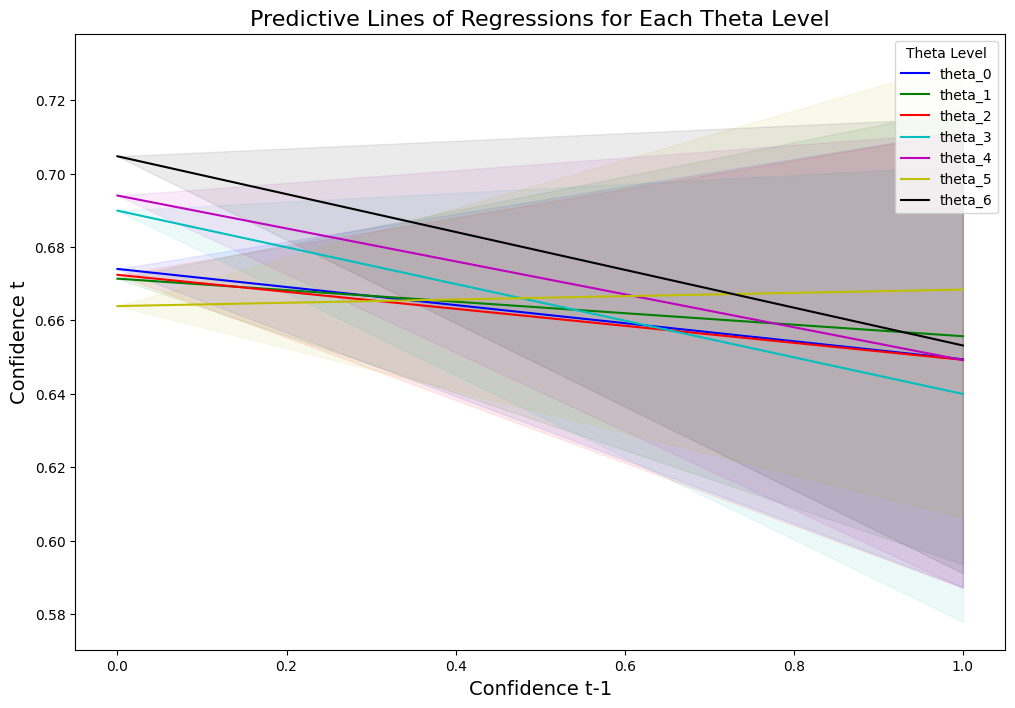

In [21]:
# Crear un rango de valores para Confidence t-1
confidence_t_minus_1 = np.linspace(0, 1, 100)

# Colores para cada theta
colors = ["b", "g", "r", "c", "m", "y", "k"]

# Crear la figura
plt.figure(figsize=(12, 8))

# Plotear las líneas predictivas de cada regresión
for idx, row in df_results_regression.iterrows():
    theta = row['theta']
    beta = row['beta']
    intercept = row['intercept']
    
    # Calcular los valores predichos de Confidence t
    confidence_t = intercept + beta * confidence_t_minus_1
    
    # Calcular los intervalos de confianza
    conf_int_low = row['conf_int_low'] * confidence_t_minus_1 + intercept
    conf_int_high = row['conf_int_high'] * confidence_t_minus_1 + intercept
    
    # Plotear la línea predictiva
    plt.plot(confidence_t_minus_1, confidence_t, label=theta, color=colors[idx])
    
    # Añadir la sombra del error predictivo
    plt.fill_between(confidence_t_minus_1, conf_int_low, conf_int_high, color=colors[idx], alpha=0.08)

# Configurar etiquetas y título con tamaños de letra más grandes
plt.xlabel('Confidence t-1', fontsize=14)
plt.ylabel('Confidence t', fontsize=14)
plt.title('Predictive Lines of Regressions for Each Theta Level', fontsize=16)
plt.legend(title='Theta Level')
plt.show()